In [1]:
## Log transform upwelling index
## verify units for all
## Update temperature rise to latest data.

## Do ocean acidification
## Storm surges


# List of variables: PP, SPM, no3, thetao
variable = 'PP'
download = False
tropicalLimit = False

In [2]:
import os, gc

import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import griddata, interp1d

import xarray as xr
import rioxarray as rxr
from pyproj import Proj, Transformer, CRS
import cmocean.cm as cmo

In [3]:
## LOAD GRID AND GET COORDINATE LOCATIONS
grid1km = rxr.open_rasterio('grid_1km_v01.1.tif',
                                 masked=True)

grid_lon, grid_lat = np.meshgrid(grid1km.x.values,grid1km.y.values)

crs = CRS.from_proj4(grid1km.rio.crs.to_proj4())
proj = Transformer.from_crs(crs, crs.geodetic_crs)

grid_lon, grid_lat = proj.transform(grid_lon,grid_lat)

In [4]:
# Data collection area
# Currently bounded by:
# Lat 42° S, 18° N
# Long 6° E, 80° E

# BASE VARIABLES

In [5]:
if download:
    if variable == 'PP':
        ! python -m motuclient \
            --motu https://my.cmems-du.eu/motu-web/Motu \
            --service-id OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082-TDS \
            --product-id dataset-oc-glo-bio-multi-l4-pp_4km_monthly-rep \
            --longitude-min 5.5 --longitude-max 80.5 --latitude-min -42.5 --latitude-max 18.56 \
            --date-min "2015-01-01 00:00:00" --date-max "2019-12-01 00:00:00" \
            --variable PP \
            --out-name CMEMS_PP.nc --user USERNAME --pwd PASSWORD
    if variable == 'SPM':
        ! python -m motuclient \
            --motu https://my.cmems-du.eu/motu-web/Motu \
            --service-id OCEANCOLOUR_GLO_OPTICS_L4_REP_OBSERVATIONS_009_081-TDS \
            --product-id dataset-oc-glo-opt-multi-l4-spm_4km_monthly-rep-v02 \
            --longitude-min 5.5 --longitude-max 80.5 --latitude-min -42.5 --latitude-max 18.56 \
            --date-min "2015-01-01 00:00:00" --date-max "2019-12-01 00:00:00" \
            --variable SPM \
            --out-name CMEMS_SPM.nc --user USERNAME --pwd PASSWORD
    if variable == 'ZSD':
        ! python -m motuclient \
            --motu https://my.cmems-du.eu/motu-web/Motu \
            --service-id OCEANCOLOUR_GLO_OPTICS_L4_REP_OBSERVATIONS_009_081-TDS \
            --product-id dataset-oc-glo-opt-multi-l4-zsd_4km_monthly-rep-v02 \
            --longitude-min 5.5 --longitude-max 80.5 --latitude-min -42.5 --latitude-max 18.56 \
            --date-min "2015-01-01 00:00:00" --date-max "2019-12-01 00:00:00" \
            --variable ZSD \
            --out-name CMEMS_ZSD.nc --user USERNAME --pwd PASSWORD
    if variable == 'no3':
        ! python -m motuclient \
            --motu https://my.cmems-du.eu/motu-web/Motu \
            --service-id GLOBAL_REANALYSIS_BIO_001_029-TDS \
            --product-id global-reanalysis-bio-001-029-monthly \
            --longitude-min 5.5 --longitude-max 80.5 --latitude-min -42.5 --latitude-max 18.56 \
            --depth-min 0 --depth-max 50 \
            --date-min "2015-01-01 00:00:00" --date-max "2019-12-01 00:00:00" \
            --variable no3 \
            --out-name CMEMS_no3.nc --user USERNAME --pwd PASSWORD
    if variable == 'thetao':
        ! python -m motuclient \
            --motu https://my.cmems-du.eu/motu-web/Motu \
            --service-id GLOBAL_REANALYSIS_PHY_001_030-TDS \
            --product-id global-reanalysis-phy-001-030-monthly \
            --longitude-min 5.5 --longitude-max 80.5 --latitude-min -42.5 --latitude-max 18.56 \
            --depth-min 0 --depth-max 10 \
            --date-min "2015-01-01 00:00:00" --date-max "2019-12-01 00:00:00" \
            --variable thetao \
            --out-name CMEMS_thetao.nc --user USERNAME --pwd PASSWORD

In [6]:
## LOAD UP CMEMS DATA FILE
data = xr.open_dataset('CMEMS_'+variable+'.nc')
data

<xarray.Dataset>
Dimensions:  (time: 60, lat: 1466, lon: 1801)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2019-12-01
  * lat      (lat) float32 18.56 18.52 18.48 18.44 ... -42.4 -42.44 -42.48
  * lon      (lon) float32 5.479 5.521 5.563 5.604 ... 80.35 80.4 80.44 80.48
Data variables:
    PP       (time, lat, lon) float32 ...
Attributes: (12/65)
    comment:                      average
    distribution_statement:       See CMEMS Data License
    site_name:                    GLO
    parameter_code:               PP
    creation_time:                22:35:27 UTC
    creation_date:                2021-10-28 UTC
    ...                           ...
    history:                      
    History:                      Translated to CF-1.0 Conventions by Netcdf-...
    geospatial_lat_min:           -42.47917175292969
    geospatial_lat_max:           18.562498092651367
    geospatial_lon_min:           5.479172229766846
    geospatial_lon_max:           80.47917175292969

In [7]:
if 'depth' in data.dims:
    data = data.mean(dim='depth')

In [8]:
# Average months together first, then by season, then by year to limit impact of reduced data at certain times of year-
month_length = data.time.dt.days_in_month

# Calculate the weights by grouping by 'time.month'.
weights = month_length.groupby('time.month') / month_length.groupby('time.month').sum()

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby('time.month').sum().values, np.ones(12))

# Calculate the weighted average
clim = (data * weights).groupby('time.month').sum(dim='time')
data.close()

In [9]:
# Now do climatological average
out = clim.mean(dim='month')

In [10]:
if 'lon' in data.dims:
    lons, lats = np.meshgrid(out.lon.values,out.lat.values) 
    valid = np.isfinite(out[variable].values.flatten())
if 'longitude' in data.dims:
    lons, lats = np.meshgrid(out.longitude.values,out.latitude.values) 
    valid = np.isfinite(out[variable].values.flatten())

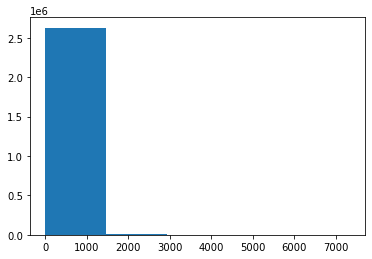

In [11]:
_ = plt.hist(out[variable].values.flatten(),5)

In [12]:
def interp(x):
    _gd = np.isfinite(x)
    return interp1d(np.arange(len(x))[_gd],x[_gd], bounds_error=False, fill_value=np.NaN)(np.arange(len(x)))

filtered = out[variable].values.copy()
filtered[filtered < 0.1] = np.NaN
r,c = np.shape(filtered)

for idx in range(r):
    filtered[idx,:] = interp(filtered[idx,:])

out[variable] = (('latitude','longitude') , filtered)

In [13]:
raster = griddata((lons.flatten()[valid], lats.flatten()[valid]), out[variable].values.flatten()[valid] , (grid_lon, grid_lat))

In [14]:
if (variable == 'thetao') and tropicalLimit:
    raster = raster-24
    raster[raster < 0] = 0
    raster = raster/2.5
    raster[raster > 1] = 1
    raster[grid_lat > 0] = 1
    out = out.rename({variable : 'tropicalLimit'})
    variable='tropicalLimit'

In [15]:
grid1km = grid1km.mean('band')
grid1km.values = (grid1km.values*0 + raster)*1000

In [16]:
grid1km

<xarray.DataArray (y: 5961, x: 7633)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 -4.405e+05 -4.395e+05 ... 7.19e+06 7.192e+06
  * y            (y) float64 1.79e+06 1.788e+06 ... -4.17e+06 -4.17e+06
    spatial_ref  int32 0

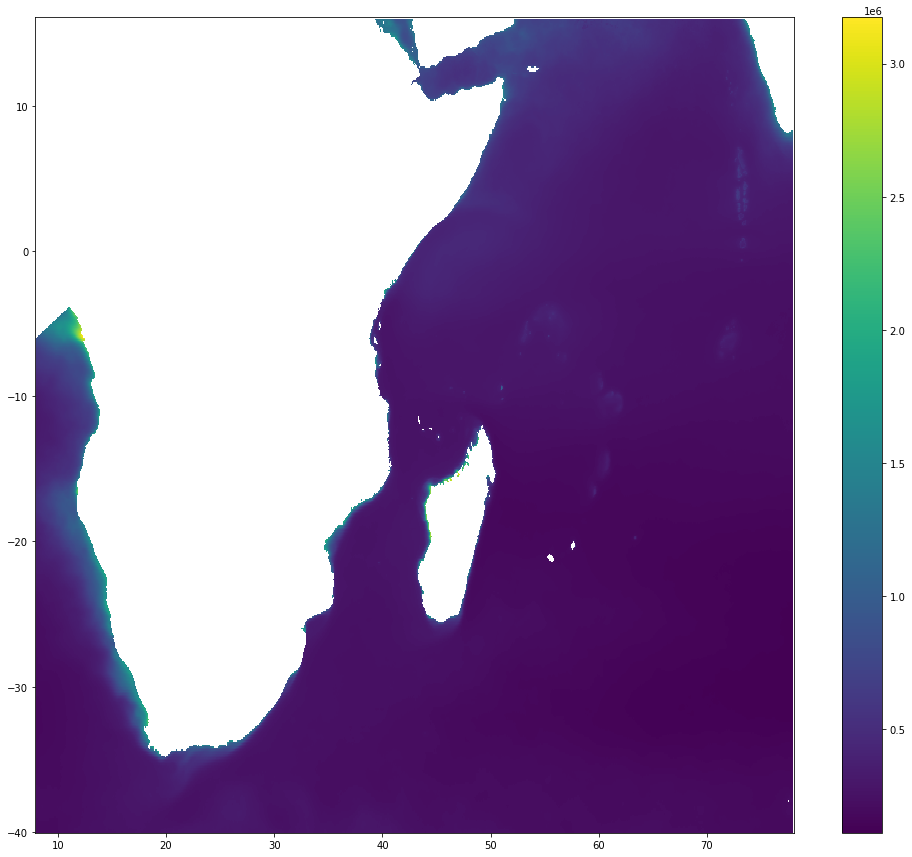

In [17]:
if (variable == 'tropicalLimit'):
    print('adjusting')
    ind = (grid_lon < 18) & (grid_lat > (-1.4*(grid_lon-5))) & np.isfinite(grid1km.values)
    grid1km = grid1km.where(~ind,1000)
    
x = 10
plt.figure(figsize=(17,15))
plt.pcolormesh(grid_lon[::x,::x], grid_lat[::x,::x], grid1km.values[::x,::x], shading='auto')
plt.colorbar()

In [18]:
grid1km.attrs['scale_factor'] = 1000
grid1km.rio.to_raster("grid_1km_"+variable+"_byq.tif",dtype='float64')

In [19]:
grid1km

<xarray.DataArray (y: 5961, x: 7633)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 -4.405e+05 -4.395e+05 ... 7.19e+06 7.192e+06
  * y            (y) float64 1.79e+06 1.788e+06 ... -4.17e+06 -4.17e+06
    spatial_ref  int32 0
Attributes:
    scale_factor:  1000

# WARMING

In [ ]:
# ! python -m motuclient \
#     --motu https://my.cmems-du.eu/motu-web/Motu \
#     --service-id GLOBAL_MULTIYEAR_PHY_001_030-TDS \
#     --product-id cmems_mod_glo_phy_my_0.083_P1M-m \
#     --longitude-min 5.5 --longitude-max 80.5 --latitude-min -42.5 --latitude-max 18.56 \
#     --depth-min 5 --depth-max 10 \
#     --date-min "2010-01-01 00:00:00" --date-max "2020-01-01 00:00:00" \
#     --variable thetao \
#     --out-name CMEMS_thetao_10-20.nc --user USERNAME --pwd PASSWORD

# ! python -m motuclient \
#     --motu https://my.cmems-du.eu/motu-web/Motu \
#     --service-id GLOBAL_MULTIYEAR_PHY_001_030-TDS \
#     --product-id cmems_mod_glo_phy_my_0.083_P1M-m \
#     --longitude-min 5.5 --longitude-max 80.5 --latitude-min -42.5 --latitude-max 18.56 \
#     --depth-min 5 --depth-max 10 \
#     --date-min "1993-01-01 00:00:00" --date-max "2003-01-01 00:00:00" \
#     --variable thetao \
#     --out-name CMEMS_thetao_93-03.nc --user USERNAME --pwd PASSWORD

In [ ]:
grid1km = rxr.open_rasterio('grid_1km_v01.1.tif',
                                 masked=True)
grid_lon, grid_lat = np.meshgrid(grid1km.x.values,grid1km.y.values)
crs = CRS.from_proj4(grid1km.rio.crs.to_proj4())
proj = Transformer.from_crs(crs, crs.geodetic_crs)
grid_lon, grid_lat = proj.transform(grid_lon,grid_lat)

# https://resources.marine.copernicus.eu/product-detail/GLOBAL_OMI_TEMPSAL_sst_trend/INFORMATION

out = xr.open_dataset('global_omi_tempsal_sst_trend_19932020_P20210312.nc')

# Lat 42° S, 18° N
# Long 6° E, 80° E
out = out.where( (out['longitude'] > 5) & (out['longitude'] < 81) & (out['latitude'] > -43) & (out['latitude'] < 19) )
out.close()

lons, lats = np.meshgrid(out.longitude.values,out.latitude.values) 
valid = np.isfinite(out['sst_trends'].values.flatten())
    
raster = griddata((lons.flatten()[valid], lats.flatten()[valid]), out['sst_trends'].values.flatten()[valid] , (grid_lon, grid_lat))

grid1km = grid1km.mean('band')
grid1km.values = (grid1km.values*0 + raster)*1000

x = 10
plt.figure(figsize=(7,5))
plt.pcolormesh(grid_lon[::x,::x], grid_lat[::x,::x], grid1km.values[::x,::x]/1000, shading='auto')
plt.colorbar()
# plt.clim([0,1])

plt.savefig('sst_trends.png', bbox_inches='tight')

grid1km.attrs['scale_factor'] = 1000
grid1km.rio.to_raster("sst_trends.tif",dtype='float64')

# SEA LEVEL RISE

In [ ]:
grid1km = rxr.open_rasterio('grid_1km_v01.1.tif',
                                 masked=True)
grid_lon, grid_lat = np.meshgrid(grid1km.x.values,grid1km.y.values)
crs = CRS.from_proj4(grid1km.rio.crs.to_proj4())
proj = Transformer.from_crs(crs, crs.geodetic_crs)
grid_lon, grid_lat = proj.transform(grid_lon,grid_lat)

# https://resources.marine.copernicus.eu/product-detail/GLOBAL_OMI_TEMPSAL_sst_trend/INFORMATION

out = xr.open_dataset('global_omi_sl_regional_trends_19930101_P20210908.nc')
out

In [ ]:
# Lat 42° S, 18° N
# Long 6° E, 80° E
out = out.where( (out['longitude'] > 5) & (out['longitude'] < 81) & (out['latitude'] > -43) & (out['latitude'] < 19) )
out.close()

lons, lats = np.meshgrid(out.longitude.values,out.latitude.values) 
valid = np.isfinite(out['msl_trend'].values.flatten())
    
raster = griddata((lons.flatten()[valid], lats.flatten()[valid]), out['msl_trend'].values.flatten()[valid] , (grid_lon, grid_lat))

grid1km = grid1km.mean('band')
grid1km.values = (grid1km.values*0 + raster)*1000

x = 10
plt.figure(figsize=(7,5))
plt.pcolormesh(grid_lon[::x,::x], grid_lat[::x,::x], grid1km.values[::x,::x]/1000, shading='auto')
plt.colorbar()
# plt.clim([0,1])

plt.savefig('msl_trends.png', bbox_inches='tight')

grid1km.attrs['scale_factor'] = 1000
grid1km.rio.to_raster("msl_trends.tif",dtype='float64')

# UPWELLING

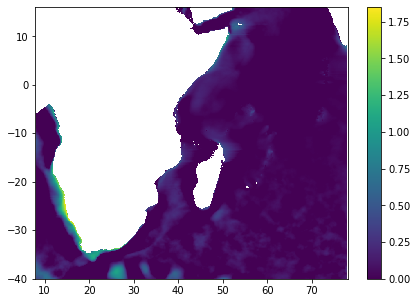

In [21]:
grid1km = rxr.open_rasterio('grid_1km_v01.1.tif',
                                 masked=True)
grid_lon, grid_lat = np.meshgrid(grid1km.x.values,grid1km.y.values)
crs = CRS.from_proj4(grid1km.rio.crs.to_proj4())
proj = Transformer.from_crs(crs, crs.geodetic_crs)
grid_lon, grid_lat = proj.transform(grid_lon,grid_lat)

data = xr.open_dataset('CMEMS_thetao_10-20.nc').mean(dim='depth') - xr.open_dataset('CMEMS_thetao_10-20.nc').mean(dim='depth').rolling(longitude=12*12, center=True,min_periods=1).mean(dim='latitude')
month_length = data.time.dt.days_in_month
weights = month_length.groupby('time.month') / month_length.groupby('time.month').sum()
np.testing.assert_allclose(weights.groupby('time.month').sum().values, np.ones(12))
clim = (data * weights).groupby('time.month').sum(dim='time')
data.close()
out = clim.mean(dim='month')

lons, lats = np.meshgrid(out.longitude.values,out.latitude.values) 
valid = np.isfinite(out['thetao'].values.flatten())
    
raster = -griddata((lons.flatten()[valid], lats.flatten()[valid]), out['thetao'].values.flatten()[valid] , (grid_lon, grid_lat))
raster[raster < 0] = 0

grid1km = grid1km.mean('band')
grid1km.values = (grid1km.values*0 + np.log(raster+1))*1000

x = 10
plt.figure(figsize=(7,5))
plt.pcolormesh(grid_lon[::x,::x], grid_lat[::x,::x], grid1km.values[::x,::x]/1000, shading='auto')
plt.colorbar()
# plt.clim([0,1])

plt.savefig('grid_1km_upwelling_byq.tif.png', bbox_inches='tight')

grid1km.attrs['scale_factor'] = 1000
grid1km.rio.to_raster("grid_1km_upwelling_byq.tif",dtype='float64')

# DEPTH ZONES

74

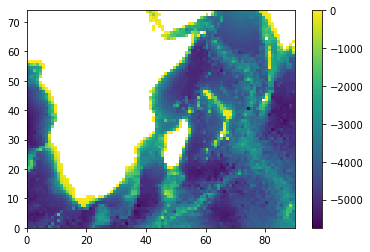

In [19]:
def extract():
    out = []
    gc.collect()
    out = xr.open_dataset('D:/Storage/Datasets/Bathymetry/GEBCO_2021_sub_ice_topo.nc', drop_variables='crs', chunks='auto')
    out = out.loc[dict(lon=slice(5.5,80.5), lat=slice(-42.5,18.5))]
    out = out.where(out['elevation'] <= 0)
    
    plt.pcolormesh(out['elevation'][::200,::200])    
    plt.colorbar()

    
    ## LOAD GRID AND GET COORDINATE LOCATIONS
    grid1km = rxr.open_rasterio('grid_1km_v01.1.tif',
                                     masked=True)
    grid_lon, grid_lat = np.meshgrid(grid1km.x.values,grid1km.y.values)
    crs = CRS.from_proj4(grid1km.rio.crs.to_proj4())
    proj = Transformer.from_crs(crs, crs.geodetic_crs)
    grid_lon, grid_lat = proj.transform(grid_lon,grid_lat)
    
    new = xr.Dataset(coords={'lon':np.nanmean(grid_lon, axis=0), 'lat':np.nanmean(grid_lat, axis=1)})
    out = out.interp_like(new)
    
    out.compute()
    
    return out
out = extract()
gc.collect()
# Lat 42° S, 18° N
# Long 6° E, 80° E

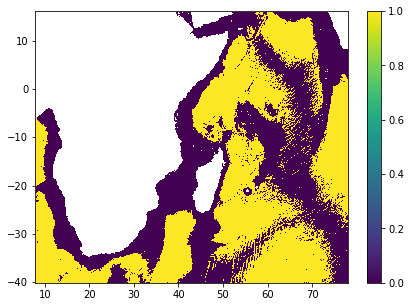

In [26]:
grid1km = rxr.open_rasterio('grid_1km_v01.1.tif',
                                 masked=True)
grid_lon, grid_lat = np.meshgrid(grid1km.x.values,grid1km.y.values)
crs = CRS.from_proj4(grid1km.rio.crs.to_proj4())
proj = Transformer.from_crs(crs, crs.geodetic_crs)
grid_lon, grid_lat = proj.transform(grid_lon,grid_lat)
grid1km = grid1km.mean('band')
grid1km.values = (grid1km.values*0 + out['elevation'].values)


grid1km.values[grid1km.values > -4000] = 0
grid1km.values[grid1km.values < 0] = 1

x = 20
plt.figure(figsize=(7,5))
plt.pcolormesh(grid_lon[::x,::x], grid_lat[::x,::x], grid1km.values[::x,::x], shading='auto')
plt.colorbar()

plt.savefig('abyssal_pelagic.png', bbox_inches='tight')
grid1km.attrs['scale_factor'] = 1
grid1km.rio.to_raster("abyssal_pelagic.tif",dtype=np.uint8)

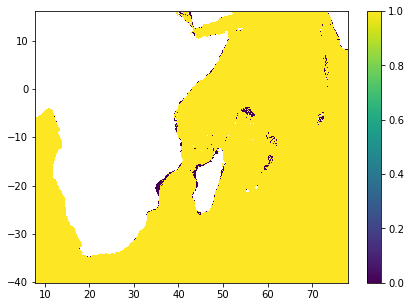

In [38]:
grid1km = rxr.open_rasterio('grid_1km_v01.1.tif',
                                 masked=True)
grid_lon, grid_lat = np.meshgrid(grid1km.x.values,grid1km.y.values)
crs = CRS.from_proj4(grid1km.rio.crs.to_proj4())
proj = Transformer.from_crs(crs, crs.geodetic_crs)
grid_lon, grid_lat = proj.transform(grid_lon,grid_lat)
grid1km = grid1km.mean('band')
grid1km.values = (grid1km.values*0 + out['elevation'].values)

zeu = rxr.open_rasterio('Products/euphotic_depth.tif',
                                 masked=True).values[0] * 3

grid1km.values[grid1km.values > -zeu] = 0
grid1km.values[grid1km.values < 0] = 1

x = 20
plt.figure(figsize=(7,5))
plt.pcolormesh(grid_lon[::x,::x], grid_lat[::x,::x], grid1km.values[::x,::x], shading='auto')
plt.colorbar()

plt.savefig('mesopelagic.png', bbox_inches='tight')
grid1km.attrs['scale_factor'] = 1
grid1km.rio.to_raster("mesopelagic.tif",dtype=np.uint8)